In [173]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import geopandas
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
df_dpnk = pd.read_csv('dpnk.csv')
df_dpnk

,OBJECTID,GID_ROAD,data_2018,data_2019,data_2020,data_2021,dpnk_22,GlobalID,SHAPE_Length
0,1,3512,0,0,0,1,2.0,{18682DE8-C98F-4A17-B74E-13614BB9274E},0.002066
1,2,3515,3,5,3,34,15.0,{F7E4061B-AD4A-4E77-8FC2-1A310314A990},0.000113
2,3,3516,10,17,10,49,14.0,{56988C51-BD9B-4AC1-806F-C5DF0CD32CCB},0.000821
3,4,4168,2,4,2,7,38.0,{9A89DC54-871A-47C8-B35F-F5E2AD66ED8F},0.001342
4,5,4169,1,1,1,18,11.0,{6245952B-3ADC-4983-A9D6-D3BB6BE633D8},0.000630
...,...,...,...,...,...,...,...,...,...
65172,65173,255288,4,6,4,0,NaN,{63553F68-9B0D-4BF7-8970-EDF1D0A6E2C7},0.000906
65173,65174,255291,2,3,2,0,NaN,{6B6B11FF-581F-43EC-BAC7-6751CA3B08B5},0.000507
65174,65175,255292,0,0,0,0,NaN,{2FA6E19A-C588-4257-B7D6-4BA5226CEF33},0.000414
65175,65176,255332,1,1,1,0,NaN,{F41405B9-2F70-493C-9D87-0E5E9C896D55},0.000164


In [4]:
print(df_dpnk['dpnk_22'].isnull().value_counts())

False    56710
True      8467
Name: dpnk_22, dtype: int64


In [5]:
df_roads = pd.read_csv('Cykloopatreni.csv')
# delka in metres
print(df_roads['typ_opatreni'].value_counts().sort_values(ascending=False))
# print(df_roads['typ_opatreni'].unique()) # Úsek byl zrušen , Vjezd cyklistům zakázán

# df_roads =  df_roads.drop(df_roads[df_roads['rok_realizace'] == 'nan'].index)
df_roads =  df_roads.drop(df_roads[df_roads['rok_realizace'] == 0].index) # deletes rows with year == 0
df_roads['rok_realizace'] = df_roads['rok_realizace'].astype('Int64') # year into int type
# substracting removed infrastructure from total length
df_roads.loc[df_roads[df_roads['typ_opatreni'] == 'Úsek byl zrušen'].index, 'delka'] = df_roads['delka'].loc[df_roads[df_roads['typ_opatreni'] == 'Úsek byl zrušen'].index] * -1
df_roads.loc[df_roads[df_roads['typ_opatreni'] == 'Vjezd cyklistům zakázán'].index, 'delka'] = df_roads['delka'].loc[df_roads[df_roads['typ_opatreni'] == 'Vjezd cyklistům zakázán'].index] * -1
df_roads

Zákaz vjezdu všech motorových vozidel - B11       112
Stezka pro chodce a cyklisty (nedělená) - C9       91
Vjezd cyklistům povolen                            90
Piktogramový koridor pro cyklisty - V20            70
Vyhrazený jízdní pruh pro cyklisty - V14           49
Jízda cyklistů v protisměru - E12                  48
Jízda cyklistů v protisměru (piktogram)            42
Přejezd pro cyklisty                               23
Stezka pro chodce a cyklisty (dělená) - C10        15
Stezka pro cyklisty - C8                           14
Stezka pro chodce s povoleným vjezdem cyklistů     12
Vyhrazený pruh pro taxi, cyklo, bus                 8
Vjezd cyklistům zakázán                             7
Jízda cyklistů v protisměru (jízdní pruh)           7
Úsek byl zrušen                                     5
Ochranný jízdní pruh pro cyklisty                   3
Ostatní                                             3
Name: typ_opatreni, dtype: int64


,ObjectId,ogcfid,typ_opatreni,rok_realizace,delka,datum_exportu,GlobalID,SHAPE_Length
0,1,639,Jízda cyklistů v protisměru (piktogram),2021,149.770000,2022/12/16 00:00:00+00,{F1050389-0266-46A5-8281-AD60711AE90A},0.002029
1,2,297,Jízda cyklistů v protisměru (piktogram),2017,71.870003,2022/12/16 00:00:00+00,{04371385-F368-42FD-9B83-3DAD4033D0EE},0.000657
2,3,712,Stezka pro chodce s povoleným vjezdem cyklistů,2022,53.349998,2022/12/16 00:00:00+00,{39E0D50A-C566-4DF7-9BFA-6F603262172E},0.000486
3,4,641,Jízda cyklistů v protisměru (piktogram),2021,248.250000,2022/12/16 00:00:00+00,{84B6FC27-C62C-4AB4-9761-2117FF06B4A0},0.003363
4,5,336,Piktogramový koridor pro cyklisty - V20,2015,81.139999,2022/12/16 00:00:00+00,{C5C495C3-0BB3-4AEA-BAF0-8C61C062742A},0.000821
...,...,...,...,...,...,...,...,...
594,595,452,Vjezd cyklistům povolen,2015,17.150000,2022/12/16 00:00:00+00,{E8439F05-0558-4327-B7EB-A345D64EB462},0.000235
595,596,298,Jízda cyklistů v protisměru (piktogram),2014,130.990010,2022/12/16 00:00:00+00,{8251BC80-4D0F-40E3-987B-23BF466A0AEB},0.001463
596,597,152,Jízda cyklistů v protisměru - E12,2014,153.330000,2022/12/16 00:00:00+00,{402C1981-C3AC-4164-88ED-2473DD3BFB08},0.000000
597,598,299,Piktogramový koridor pro cyklisty - V20,2014,132.759990,2022/12/16 00:00:00+00,{F03B079F-9DF5-475F-B46D-0AD4A7FEE5D2},0.000000


In [6]:
dff = df_roads.dropna(subset='rok_realizace')

In [7]:
# total number of cyclists per year
df2 = df_dpnk[['data_2018', 'data_2019', 'data_2020', 'data_2021', 'dpnk_22']].sum(axis=0).reset_index()
df2['rok'] = range(2018,2023)
# counting number of segments made before each year
df2.loc[0, 'num_opatreni'] = df_roads['rok_realizace'].loc[df_roads[df_roads['rok_realizace'] < 2018].index].count()
# substracting removed infrastructure from count
df2.loc[0, 'num_opatreni'] -= df_roads.loc[df_roads[df_roads['delka'] < 0].index].shape[0]
# total number of segments
df2.loc[0, 'total_num'] = 0
# length of segments made before each year [m]
df2.loc[0, 'length_opatreni'] = df_roads['delka'].loc[df_roads[df_roads['rok_realizace'] < 2018].index].sum().round()
for i in range(4):
    df2.loc[i+1, 'num_opatreni'] = df_roads['rok_realizace'].loc[df_roads[df_roads['rok_realizace'] == 2018+i].index].count()
    df2.loc[i+1, 'length_opatreni'] = df_roads['delka'].loc[df_roads[df_roads['rok_realizace'] == 2018+i].index].sum().round()
    df2.loc[i+1, 'total_length'] = df_roads['delka'].loc[df_roads[df_roads['rok_realizace'] <= 2018+i].index].sum().round()
df2['total_num'] = df2['num_opatreni'].cumsum()
# total length of segments [km]
df2['total_length'] = (df2['length_opatreni'].cumsum() / 1000).round(1)
df2.rename(columns={'index': 'popis', 0: 'num_cyclists'}, inplace=True)
df2

,popis,num_cyclists,rok,num_opatreni,total_num,length_opatreni,total_length
0,data_2018,1571704.0,2018,415.0,415.0,103435.0,103.4
1,data_2019,2570673.0,2019,35.0,450.0,8707.0,112.1
2,data_2020,1549761.0,2020,27.0,477.0,5739.0,117.9
3,data_2021,3299232.0,2021,13.0,490.0,3912.0,121.8
4,dpnk_22,3652385.0,2022,21.0,511.0,6044.0,127.8


In [8]:
# linear regression X=length of cycling ingrastructure, y=number of cyclists each year
X = df2.loc[:3, 'total_length'].to_numpy().reshape(-1,1)
y = df2.loc[:3, 'num_cyclists']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
regr = linear_model.LinearRegression()
regr.fit(X, y)
print('prediction of 127.8:' ,regr.predict([[127.8]]).round())

prediction of 127.8: [3125817.]


<AxesSubplot: xlabel='total_length', ylabel='num_cyclists'>

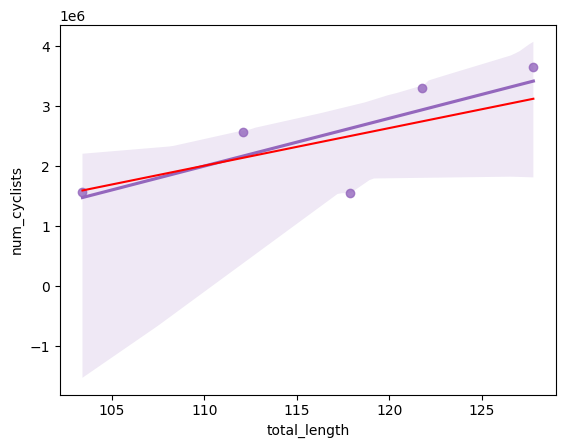

In [9]:
# sns.lmplot(data=df2, x='total_length', y='num_cyclists')
sns.regplot(data=df2, x='total_length', y='num_cyclists', color='tab:purple', ci=95)
sns.lineplot(x=df2['total_length'], y=regr.intercept_ + regr.coef_* df2['total_length'], color='red')

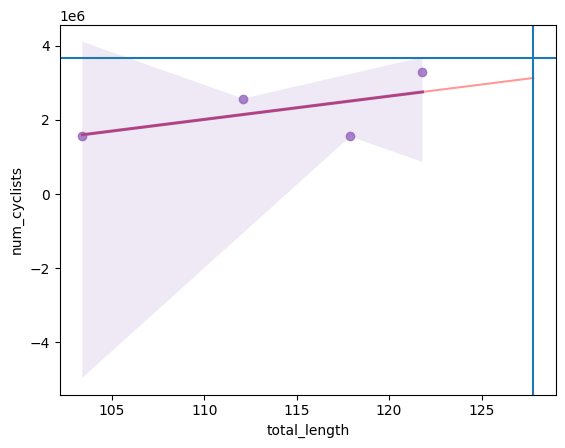

In [10]:
g = sns.regplot(data=df2.iloc[:4], x='total_length', y='num_cyclists', color='tab:purple', ci=95)
sns.lineplot(x=df2['total_length'], y=regr.intercept_ + regr.coef_* df2['total_length'], color='red', alpha=0.4)
g.axhline(df2.loc[4, 'num_cyclists'])
g.axvline(df2.loc[4, 'total_length'])


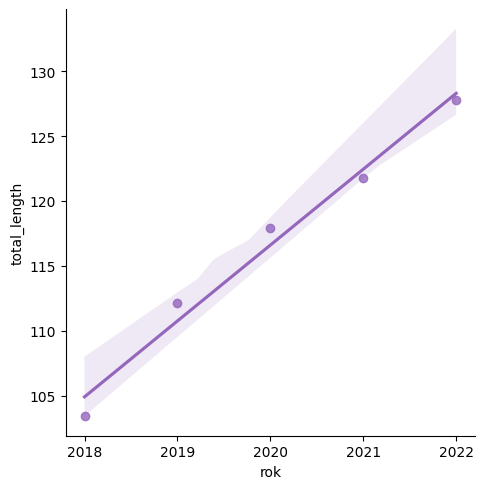

In [11]:
# linear regression length of cycling infrastacture
sns.set_palette(sns.color_palette(['tab:purple']))
g = sns.lmplot(data=df2, x='rok', y='total_length', ci=95)
g.set(xticks=range(2018,2023))

<AxesSubplot: xlabel='rok', ylabel='num_cyclists'>

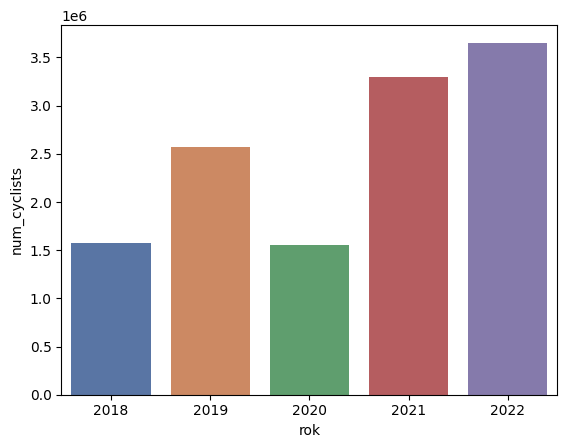

In [12]:
sns.set_palette('deep')
sns.barplot(data = df2, x='rok', y='num_cyclists')

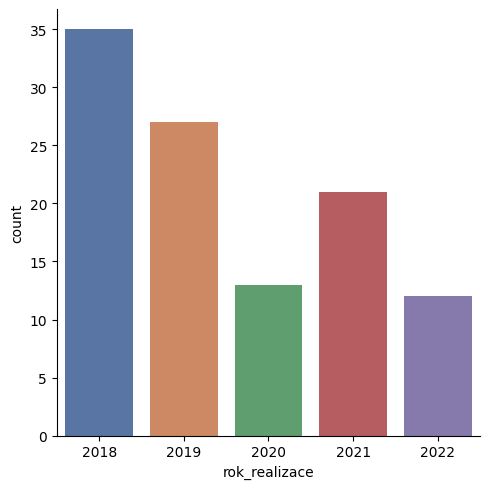

In [13]:
# count of new infrastructure each year
g = sns.catplot(dff, x='rok_realizace', kind='count', order=range(2018,2023))

In [14]:
# num cycklists before change, after change
# one-hot type of change
# same with no change for compare
# train it
# predict? 

In [15]:
# 4 years train, 1 year test
# Linear regression
df_clean = df_dpnk.dropna(subset='dpnk_22')
df_clean.head()

,OBJECTID,GID_ROAD,data_2018,data_2019,data_2020,data_2021,dpnk_22,GlobalID,SHAPE_Length
0,1,3512,0,0,0,1,2.0,{18682DE8-C98F-4A17-B74E-13614BB9274E},0.002066
1,2,3515,3,5,3,34,15.0,{F7E4061B-AD4A-4E77-8FC2-1A310314A990},0.000113
2,3,3516,10,17,10,49,14.0,{56988C51-BD9B-4AC1-806F-C5DF0CD32CCB},0.000821
3,4,4168,2,4,2,7,38.0,{9A89DC54-871A-47C8-B35F-F5E2AD66ED8F},0.001342
4,5,4169,1,1,1,18,11.0,{6245952B-3ADC-4983-A9D6-D3BB6BE633D8},0.000630


In [16]:
X = df_clean[['data_2018', 'data_2019', 'data_2020', 'data_2021']]
y = df_clean['dpnk_22']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print('train score:', regr.score(X_train, y_train))
pred = regr.predict(X_test)
print('mean squared error:', mean_squared_error(y_test, pred))
print('r2 score:', r2_score(y_test, pred))
print('mean absolute error:', mean_absolute_error(y_test, pred))
print('sum of y_test:', y_test.sum().round())
print('sum of pred:', pred.sum().round())

train score: 0.8965262258784883
mean squared error: 2380.900464730803
r2 score: 0.9024021440395821
mean absolute error: 21.351562903191475
sum of y_test: 1451867.0
sum of pred: 1455311.0


In [17]:
geo_roads = geopandas.read_file('cykloopatreni_json.geojson')
geo_roads =  geo_roads.drop(geo_roads[geo_roads['rok_realizace'] == 0].index) # deletes rows with year == 0

In [18]:
geo_roads['centroid'] = geo_roads['geometry'].to_crs(crs=3857).centroid
geo_roads['centroid'] = geo_roads['centroid'].to_crs(crs=4326)
geo_roads.head()

,ObjectId,ogcfid,typ_opatreni,rok_realizace,delka,datum_exportu,GlobalID,SHAPE_Length,geometry,centroid
0,1,639,Jízda cyklistů v protisměru (piktogram),2021.0,149.770000,2022-12-16 00:00:00+00:00,{F1050389-0266-46A5-8281-AD60711AE90A},0.002029,"MULTILINESTRING ((16.59897 49.19989, 16.60020 ...",POINT (16.59998 49.20003)
1,2,297,Jízda cyklistů v protisměru (piktogram),2017.0,71.870003,2022-12-16 00:00:00+00:00,{04371385-F368-42FD-9B83-3DAD4033D0EE},0.000657,"MULTILINESTRING ((16.61335 49.19660, 16.61274 ...",POINT (16.61304 49.19648)
2,3,712,Stezka pro chodce s povoleným vjezdem cyklistů,2022.0,53.349998,2022-12-16 00:00:00+00:00,{39E0D50A-C566-4DF7-9BFA-6F603262172E},0.000486,"MULTILINESTRING ((16.64647 49.19613, 16.64645 ...",POINT (16.64642 49.19636)
3,4,641,Jízda cyklistů v protisměru (piktogram),2021.0,248.250000,2022-12-16 00:00:00+00:00,{84B6FC27-C62C-4AB4-9761-2117FF06B4A0},0.003363,"MULTILINESTRING ((16.59679 49.19958, 16.59631 ...",POINT (16.59513 49.19935)
4,5,336,Piktogramový koridor pro cyklisty - V20,2015.0,81.139999,2022-12-16 00:00:00+00:00,{C5C495C3-0BB3-4AEA-BAF0-8C61C062742A},0.000821,"MULTILINESTRING ((16.60728 49.19359, 16.60718 ...",POINT (16.60707 49.19391)


In [19]:
geo_dpnk = geopandas.read_file('dpnk_json.geojson')

In [172]:
geo_dpnk['centroid'] = geo_dpnk['geometry'].to_crs(crs=3857).centroid # to metres
geo_dpnk['centroid'] = geo_dpnk['centroid'].to_crs(crs=4326) # to degrees
geo_dpnk['sum_years'] = geo_dpnk[geo_dpnk.columns[2:7]].sum(axis=1)
geo_dpnk.head()


,OBJECTID,GID_ROAD,data_2018,data_2019,data_2020,data_2021,dpnk_22,GlobalID,SHAPE_Length,geometry,centroid,sum_years
0,1,3512.0,0,0,0,1,2.0,{18682DE8-C98F-4A17-B74E-13614BB9274E},0.002066,"MULTILINESTRING ((16.69839 49.30872, 16.69838 ...",POINT (16.69844 49.30969),3.0
1,2,3515.0,3,5,3,34,15.0,{F7E4061B-AD4A-4E77-8FC2-1A310314A990},0.000113,"MULTILINESTRING ((16.66312 49.29681, 16.66320 ...",POINT (16.66316 49.29685),60.0
2,3,3516.0,10,17,10,49,14.0,{56988C51-BD9B-4AC1-806F-C5DF0CD32CCB},0.000821,"MULTILINESTRING ((16.66234 49.29709, 16.66312 ...",POINT (16.66273 49.29695),100.0
3,4,4168.0,2,4,2,7,38.0,{9A89DC54-871A-47C8-B35F-F5E2AD66ED8F},0.001342,"MULTILINESTRING ((16.64117 49.39327, 16.64130 ...",POINT (16.64183 49.39321),53.0
4,5,4169.0,1,1,1,18,11.0,{6245952B-3ADC-4983-A9D6-D3BB6BE633D8},0.000630,"MULTILINESTRING ((16.64110 49.39303, 16.64173 ...",POINT (16.64142 49.39304),32.0


In [208]:
# ##################################
# clustering by number of cyclists per road, sum of all years , df = geo_dpnk
ww = pd.concat([geo_dpnk['centroid'].x, geo_dpnk['centroid'].y], axis=1)
kmeans = KMeans(n_clusters=8, n_init='auto').fit(ww)
geo_dpnk['kmeans'] = kmeans.predict(ww)
geo_dpnk.head()

,OBJECTID,GID_ROAD,data_2018,data_2019,data_2020,data_2021,dpnk_22,GlobalID,SHAPE_Length,geometry,centroid,sum_years,kmeans
0,1,3512.0,0,0,0,1,2.0,{18682DE8-C98F-4A17-B74E-13614BB9274E},0.002066,"MULTILINESTRING ((16.69839 49.30872, 16.69838 ...",POINT (16.69844 49.30969),3.0,2
1,2,3515.0,3,5,3,34,15.0,{F7E4061B-AD4A-4E77-8FC2-1A310314A990},0.000113,"MULTILINESTRING ((16.66312 49.29681, 16.66320 ...",POINT (16.66316 49.29685),60.0,2
2,3,3516.0,10,17,10,49,14.0,{56988C51-BD9B-4AC1-806F-C5DF0CD32CCB},0.000821,"MULTILINESTRING ((16.66234 49.29709, 16.66312 ...",POINT (16.66273 49.29695),100.0,2
3,4,4168.0,2,4,2,7,38.0,{9A89DC54-871A-47C8-B35F-F5E2AD66ED8F},0.001342,"MULTILINESTRING ((16.64117 49.39327, 16.64130 ...",POINT (16.64183 49.39321),53.0,2
4,5,4169.0,1,1,1,18,11.0,{6245952B-3ADC-4983-A9D6-D3BB6BE633D8},0.000630,"MULTILINESTRING ((16.64110 49.39303, 16.64173 ...",POINT (16.64142 49.39304),32.0,2


<AxesSubplot: >

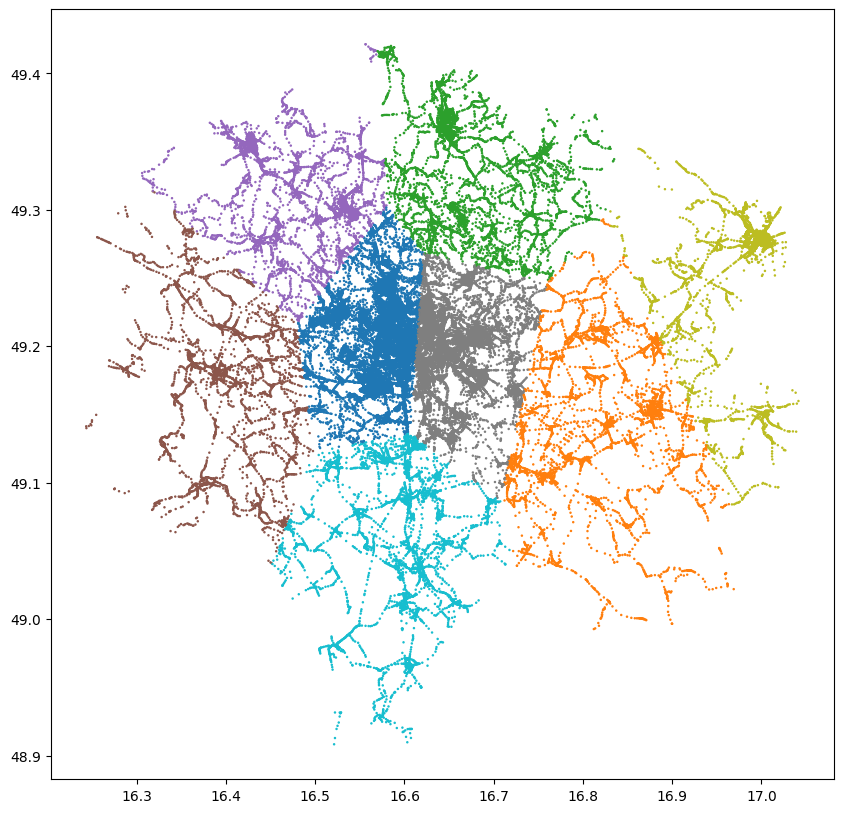

In [209]:
fig, ax = plt.subplots(figsize=(12,10))
geo_dpnk =  geo_dpnk.set_geometry('centroid') # chosing to plot centroids
geo_dpnk.plot(markersize=0.6, ax=ax, column='kmeans', cmap='tab10')
ctx.add_basemap(ax, crs=joined.crs.to_string(), source=ctx.providers.CartoDB.Positron) #OpenStreetMap.Mapnik # Stamen.Tonerlite

In [21]:
xx = geo_dpnk['centroid'].to_crs(crs=3857)
yy = geo_roads['centroid'].to_crs(crs=3857)
ww = xx.loc[xx[xx.distance(yy.iloc[0]) < 150].index]
ww

37312    POINT (1847912.698 6308876.654)
45424    POINT (1847991.523 6308948.524)
Name: centroid, dtype: geometry

In [139]:
# ##################################################################################
# joining datasets together, needed to change CRS to metres and then back
geo_dpnk['geometry'] = geo_dpnk['geometry'].to_crs(crs=3857)
geo_roads['geometry'] = geo_roads['geometry'].to_crs(crs=3857)
joined = geopandas.sjoin_nearest(geo_roads, geo_dpnk, distance_col='distance', how='left')
joined['geometry'] = geo_roads['geometry'].to_crs(crs=4326)
geo_dpnk['geometry'] = geo_dpnk['geometry'].to_crs(crs=4326)
geo_roads['geometry'] = geo_roads['geometry'].to_crs(crs=4326)
joined.iloc[6:].head()

,ObjectId,ogcfid,typ_opatreni,rok_realizace,delka,datum_exportu,GlobalID_left,SHAPE_Length_left,geometry,centroid_left,...,GID_ROAD,data_2018,data_2019,data_2020,data_2021,dpnk_22,GlobalID_right,SHAPE_Length_right,centroid_right,distance
5,6,693,Piktogramový koridor pro cyklisty - V20,2021.0,739.69,2022-12-16 00:00:00+00:00,{1E0CDE6A-89D0-4759-ABCE-AD655E21CF36},0.007623,"MULTILINESTRING ((16.61753 49.18661, 16.61746 ...",POINT (16.61621 49.18817),...,254125.0,93.0,152.0,92.0,39.0,98.0,{2630B38D-5D94-4E2D-85D6-F8C21AC93EB7},0.000905,POINT (16.61604 49.18823),0.0
5,6,693,Piktogramový koridor pro cyklisty - V20,2021.0,739.69,2022-12-16 00:00:00+00:00,{1E0CDE6A-89D0-4759-ABCE-AD655E21CF36},0.007623,"MULTILINESTRING ((16.61753 49.18661, 16.61746 ...",POINT (16.61621 49.18817),...,231801.0,70.0,114.0,69.0,40.0,132.0,{E7BA4411-EF59-451E-A5F7-5612750FA2BF},0.000374,POINT (16.61590 49.18846),0.0
5,6,693,Piktogramový koridor pro cyklisty - V20,2021.0,739.69,2022-12-16 00:00:00+00:00,{1E0CDE6A-89D0-4759-ABCE-AD655E21CF36},0.007623,"MULTILINESTRING ((16.61753 49.18661, 16.61746 ...",POINT (16.61621 49.18817),...,229969.0,58.0,94.0,57.0,56.0,126.0,{0505F39F-84FE-4C3C-8DC3-D3EED00E3A1E},0.000257,POINT (16.61599 49.18852),0.0
5,6,693,Piktogramový koridor pro cyklisty - V20,2021.0,739.69,2022-12-16 00:00:00+00:00,{1E0CDE6A-89D0-4759-ABCE-AD655E21CF36},0.007623,"MULTILINESTRING ((16.61753 49.18661, 16.61746 ...",POINT (16.61621 49.18817),...,229010.0,74.0,121.0,73.0,26.0,126.0,{948ED5EA-193D-4F6E-B800-AF8E2FB9E7CD},0.000221,POINT (16.61486 49.19016),0.0
5,6,693,Piktogramový koridor pro cyklisty - V20,2021.0,739.69,2022-12-16 00:00:00+00:00,{1E0CDE6A-89D0-4759-ABCE-AD655E21CF36},0.007623,"MULTILINESTRING ((16.61753 49.18661, 16.61746 ...",POINT (16.61621 49.18817),...,232272.0,10.0,16.0,10.0,10.0,16.0,{6B89F4A0-4EF8-45FA-9F45-4EA8C6E64619},0.000073,POINT (16.61474 49.19032),0.0


In [54]:
print(joined['ObjectId'].value_counts())

6      22
316    18
557    15
490    15
106    15
       ..
284     1
283     1
281     1
279     1
599     1
Name: ObjectId, Length: 534, dtype: int64


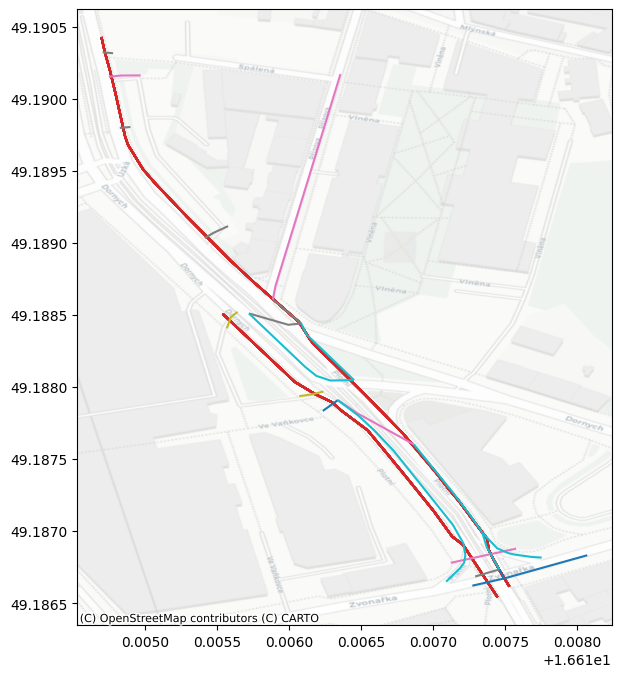

In [162]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
# geo_roads.plot(ax=ax, column='rok_realizace', alpha=0.8, label='cykloopatreni', legend=True, cmap='magma')
# geo_roads['centroid'].plot(ax=ax, color='tab:red', markersize=6, label='centroids')
# geo_roads['centroid'][geo_roads['rok_realizace'] > 2018].plot(ax=ax, color='tab:red', markersize=6, label='centroids')
joined[joined['ObjectId'] == 6].plot(ax=ax, color='tab:red')
# geo_roads[geo_roads['ObjectId'] == 6].plot(ax=ax, color='tab:blue', ls=':', markersize=20)
# geo_roads[geo_roads['ObjectId'].isin([6])].plot(ax=ax, color='tab:blue', ls=':', markersize=20)
xx = joined['GID_ROAD'][joined['ObjectId'] == 6]
geo_dpnk[geo_dpnk['GID_ROAD'].isin(xx)].plot(ax=ax, column='GID_ROAD', cmap='tab10')
ctx.add_basemap(ax, crs=joined.crs.to_string(), source=ctx.providers.CartoDB.Positron) #OpenStreetMap.Mapnik # Stamen.Tonerlite

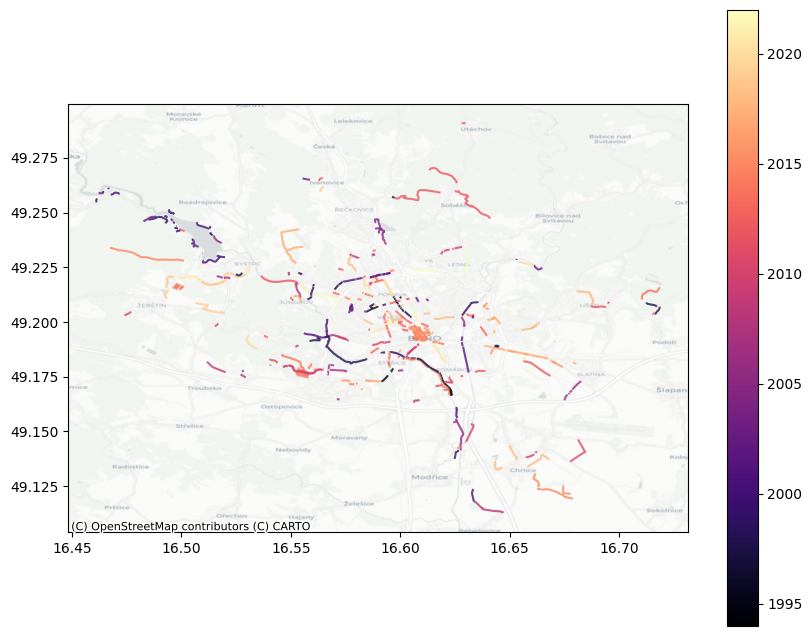

In [115]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
# geo_roads['geometry'].plot(ax=ax, color='tab:blue', alpha=0.8, label='cykloopatreni') # color='tab:blue'
geo_roads.plot(ax=ax, column='rok_realizace', alpha=0.8, label='cykloopatreni', legend=True, cmap='magma')
# geo_roads['centroid'].plot(ax=ax, color='tab:red', markersize=6, label='centroids')
# geo_roads['centroid'][geo_roads['rok_realizace'] > 2018].plot(ax=ax, color='tab:red', markersize=6, label='centroids')
# geo_dpnk['centroid'].plot(ax=ax, color='tab:green', markersize=2, label='centroids')
ctx.add_basemap(ax, crs=geo_roads.crs.to_string(), source=ctx.providers.CartoDB.Positron, alpha=0.9) #OpenStreetMap.Mapnik # Stamen.Tonerlite

<AxesSubplot: >

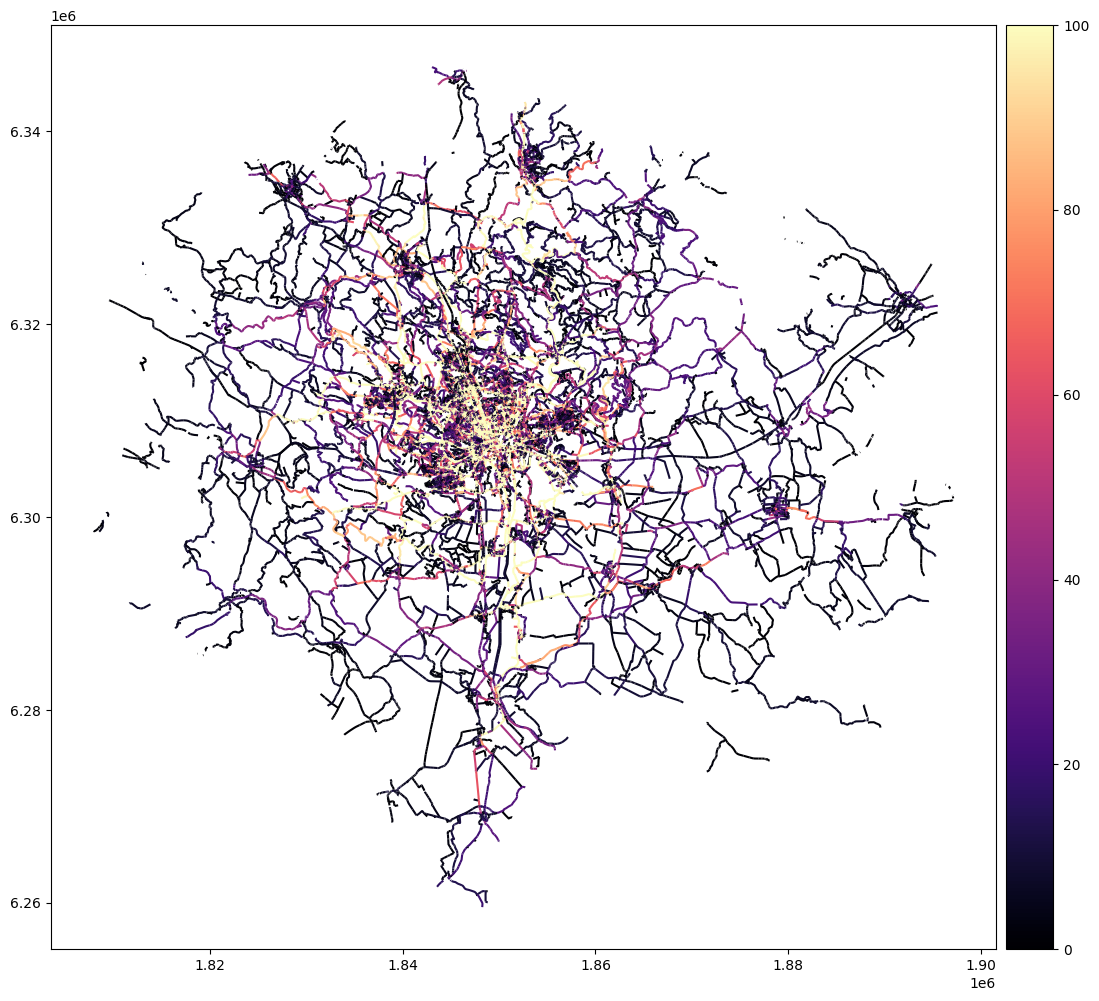

In [24]:
fig, ax = plt.subplots(1,1, figsize=(14,12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
geo_dpnk.plot(ax=ax, column='dpnk_22', label='cykloopatreni', legend=True, vmin=0, vmax=100, cax=cax, cmap='magma')

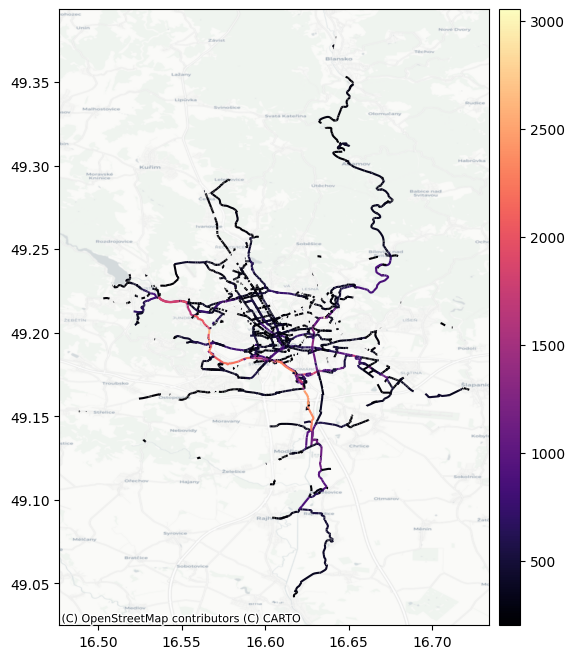

In [156]:
fig, ax = plt.subplots(figsize=(12,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
geo_dpnk[geo_dpnk['dpnk_22'] > 200].plot(ax=ax, column='dpnk_22', label='cykloopatreni', legend=True, cmap='magma', cax=cax)
ctx.add_basemap(ax, crs=geo_dpnk.crs.to_string(), source=ctx.providers.CartoDB.Positron) #OpenStreetMap.Mapnik # Stamen.Tonerlite